In [13]:
import os
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, r2_score
import hopsworks
import util
import json

import warnings
warnings.filterwarnings("ignore")

,pm25,predicted_pm25,date
1727,6.0,29.726257,2023-08-08 00:00:00+00:00
1728,10.0,24.534801,2023-08-09 00:00:00+00:00
1729,8.0,30.232702,2023-08-10 00:00:00+00:00
1730,11.0,34.008667,2023-08-11 00:00:00+00:00
1731,13.0,34.880951,2023-08-12 00:00:00+00:00


In [14]:
project = hopsworks.login()
fs = project.get_feature_store() 

secrets = util.secrets_api(project.name)
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

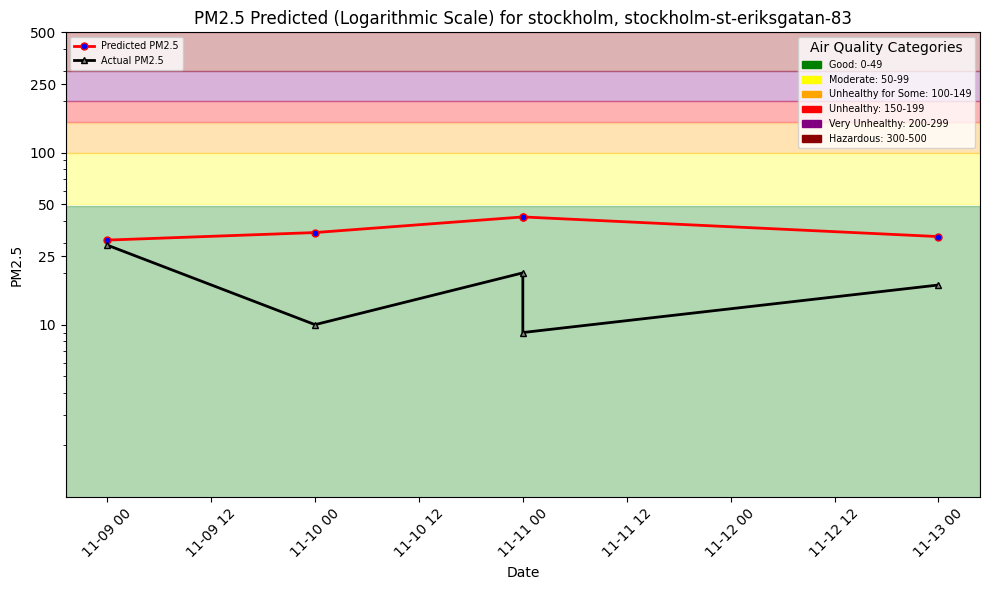

In [15]:
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=1,
)
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)

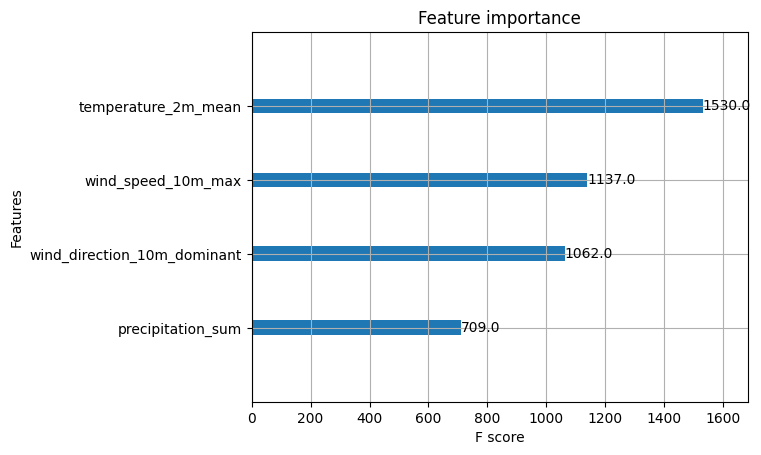

In [16]:
selected_features = air_quality_fg.select(['pm25']).join(weather_fg.select_all(), on=['city'])
selected_features.show(10)

In [17]:
feature_view = fs.get_or_create_feature_view(
    name='air_quality_fv',
    description="weather features with air quality as the target",
    version=1,
    labels=['pm25'],
    query=selected_features,
)

In [18]:
df_count=pd.read_csv("data/stockholm-st-eriksgatan-83-air-quality.csv")
def count_rows(df):
    print(len(df))
    cut_off=0.2*len(df)
    test_date=df.loc[cut_off,'date']
    test_date=test_date.replace("/", "-")
    print(test_date)
    return test_date
start_date_test_data=count_rows(df_count)

In [19]:
test_start = datetime.strptime(start_date_test_data, "%Y-%m-%d")

In [20]:
X_train, X_test, y_train, y_test = feature_view.train_test_split(
    test_start=test_start
)

Connected. Call `.close()` to terminate connection gracefully.


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/506662 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/19558 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/56244 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/108 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/645 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/1157270/models/air_quality_xgboost_model/4


Model(name: 'air_quality_xgboost_model', version: 4)

In [21]:
X_train

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,2018-04-09 00:00:00+00:00,4.087333,4.2,17.477621,25.796001,stockholm
1,2018-04-10 00:00:00+00:00,2.481083,0.2,19.406637,41.474716,stockholm
2,2018-04-11 00:00:00+00:00,2.124833,0.0,14.003029,78.284470,stockholm
3,2018-04-12 00:00:00+00:00,3.076917,0.0,14.241629,69.392525,stockholm
4,2018-04-13 00:00:00+00:00,4.774834,0.0,15.273505,83.423416,stockholm
...,...,...,...,...,...,...
1722,2023-08-03 00:00:00+00:00,16.006083,6.8,19.799999,118.752876,stockholm
1723,2023-08-04 00:00:00+00:00,16.801918,4.0,15.745627,295.249268,stockholm
1724,2023-08-05 00:00:00+00:00,16.764416,1.7,13.320000,202.097183,stockholm
1725,2023-08-06 00:00:00+00:00,16.408169,12.0,23.469128,44.330021,stockholm


In [22]:
X_test

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
1727,2023-08-08 00:00:00+00:00,15.664416,4.9,30.903435,162.897202,stockholm
1728,2023-08-09 00:00:00+00:00,14.070664,4.0,25.582806,161.041077,stockholm
1729,2023-08-10 00:00:00+00:00,13.039417,7.5,16.099689,170.896332,stockholm
1730,2023-08-11 00:00:00+00:00,14.208167,1.4,14.332341,196.760773,stockholm
1731,2023-08-12 00:00:00+00:00,16.418581,0.0,17.673029,173.943832,stockholm
...,...,...,...,...,...,...
2179,2024-11-09 00:00:00+00:00,5.618584,0.0,14.428097,257.365479,stockholm
2180,2024-11-10 00:00:00+00:00,5.512333,0.1,9.292255,145.380463,stockholm
2181,2024-11-11 00:00:00+00:00,4.908166,1.1,9.676569,234.773972,stockholm
2182,2024-11-11 00:00:00+00:00,4.908166,1.1,9.676569,234.773972,stockholm


In [23]:
train_features= X_train.drop(['date', 'city'], axis=1)
test_features = X_test.drop(['date', 'city'], axis=1)

In [24]:
y_train

,pm25
0,55.0
1,14.0
2,23.0
3,26.0
4,33.0
...,...
1722,18.0
1723,16.0
1724,20.0
1725,23.0


In [25]:
xgb_regressor = XGBRegressor()
xgb_regressor.fit(train_features, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [26]:
y_pred= xgb_regressor.predict(test_features)

mse= mean_squared_error(y_test.iloc[:,0], y_pred)
print("MSE:", mse)

r2 = r2_score(y_test.iloc[:,0], y_pred)
print("R squared:", r2)

MSE: 191.24077
R squared: -0.4737275159601324


Storing predicted log

In [27]:
df = y_test
df['predicted_pm25'] = y_pred

In [28]:
df['date']= X_test['date']
df= df.sort_values(by=['date'])
df.head(5)

,pm25,predicted_pm25,date
1727,6.0,29.726257,2023-08-08 00:00:00+00:00
1728,10.0,24.534801,2023-08-09 00:00:00+00:00
1729,8.0,30.232702,2023-08-10 00:00:00+00:00
1730,11.0,34.008667,2023-08-11 00:00:00+00:00
1731,13.0,34.880951,2023-08-12 00:00:00+00:00


In [29]:
model_dir="air_quality_model"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
images_dir=model_dir+"/images"
if not os.path.exists(images_dir):
    os.mkdir(images_dir)

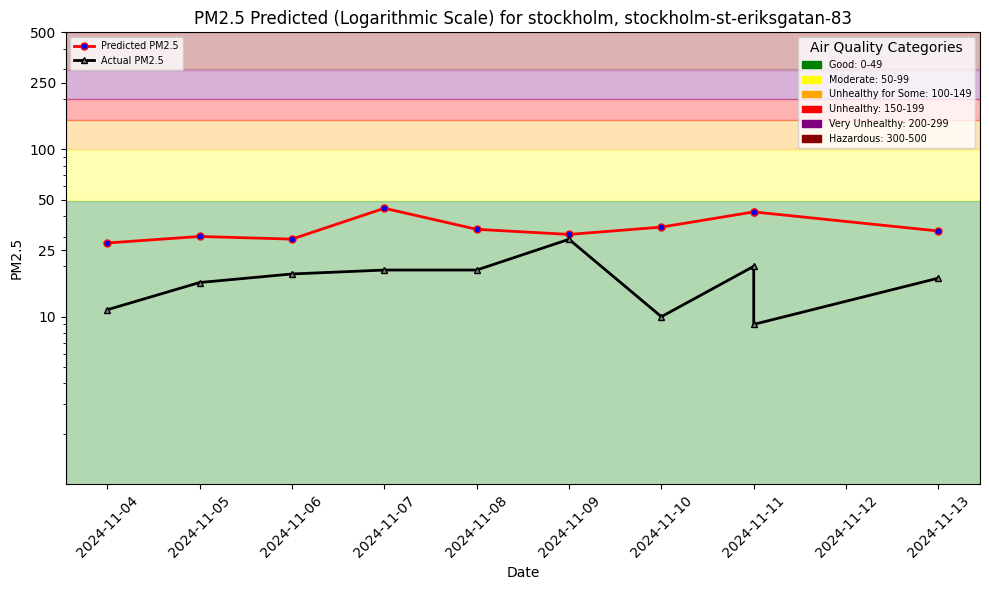

In [30]:
file_path=images_dir+"/pm25_hindcast.png"
plt=util.plot_air_quality_forecast(city, street, df.tail(10), file_path, hindcast=True)
plt.show()

In [31]:
df.tail(6)

,pm25,predicted_pm25,date
2178,19.0,33.282932,2024-11-08 00:00:00+00:00
2179,29.0,31.010441,2024-11-09 00:00:00+00:00
2180,10.0,34.298584,2024-11-10 00:00:00+00:00
2181,20.0,42.275517,2024-11-11 00:00:00+00:00
2182,9.0,42.275517,2024-11-11 00:00:00+00:00
2183,17.0,32.503288,2024-11-13 00:00:00+00:00


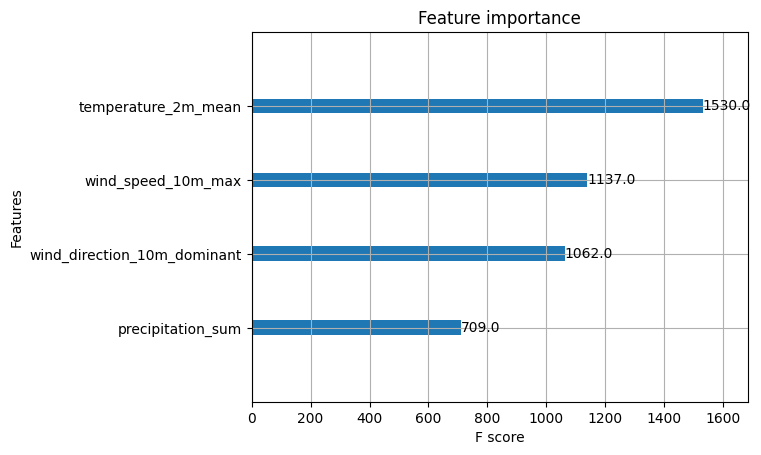

In [32]:
plot_importance(xgb_regressor, max_num_features=4)
feature_importance_path = images_dir + "/feature_importance.png"
plt.savefig(feature_importance_path)
plt.show()

In [33]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

# Creating input and output schemas using the 'Schema' class for features (X) and target variable (y)
input_schema = Schema(X_train)
output_schema = Schema(y_train)

# Creating a model schema using 'ModelSchema' with the input and output schemas
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

# Converting the model schema to a dictionary representation
schema_dict = model_schema.to_dict()

In [34]:
xgb_regressor.save_model(model_dir + "/model.json")

In [35]:
res_dict = { 
        "MSE": str(mse),
        "R squared": str(r2),
    }

In [36]:
mr = project.get_model_registry()

# Creating a Python model in the model registry named 'air_quality_xgboost_model'

aq_model = mr.python.create_model(
    name="air_quality_xgboost_model", 
    metrics= res_dict,
    model_schema=model_schema,
    input_example=X_test.sample().values, 
    description="Air Quality (PM2.5) predictor",
)

# Saving the model artifacts to the 'air_quality_model' directory in the model registry
aq_model.save(model_dir)

Connected. Call `.close()` to terminate connection gracefully.


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/506662 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/19558 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/58448 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/107 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/645 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/1157270/models/air_quality_xgboost_model/5


Model(name: 'air_quality_xgboost_model', version: 5)